# Feature Importance Analysis: Distinguishing Between Upskilling and Reskilling Programs
This notebook analyzes features that distinguish between upskilling and reskilling programs using two approaches:

1. Using all variables (including outcomes)
2. Using only program characteristics (excluding outcomes)

In [2]:
# Required Libraries
import pandas as pd
import numpy as np
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import variable definitions
from variable_definitions import (
    label_mapping, program_variables, outcomes_to_exclude, add_unique_keys
)

# Set random seed for reproducibility
np.random.seed(42)

# Configure visualization settings
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

c:\Users\user\Desktop\HBS-Survey\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Configuración de directorios para los resultados
import os

# Estructura de directorios base
base_output_dir = "../Output/Results_Feature-Importance"
figures_dir = os.path.join(base_output_dir, "Figures")
stats_dir = os.path.join(base_output_dir, "Statistics")
reports_dir = os.path.join(base_output_dir, "Reports")

# Directorios específicos para cada tipo de visualización
model_comparisons_dir = os.path.join(figures_dir, "Model_Comparisons")
feature_importance_dir = os.path.join(figures_dir, "Feature_Importance")
shap_dir = os.path.join(figures_dir, "SHAP_Analysis")

# Crear todos los directorios
for directory in [
    base_output_dir, 
    figures_dir, 
    stats_dir, 
    reports_dir,
    model_comparisons_dir,
    feature_importance_dir,
    shap_dir
]:
    os.makedirs(directory, exist_ok=True)

print(f"Estructura de directorios creada:")
print(f"- Base: {base_output_dir}")
print(f"- Figuras: {figures_dir}")
print(f"- Estadísticas: {stats_dir}")
print(f"- Reportes: {reports_dir}")


Estructura de directorios creada:
- Base: ../Output/Results_Feature-Importance
- Figuras: ../Output/Results_Feature-Importance\Figures
- Estadísticas: ../Output/Results_Feature-Importance\Statistics
- Reportes: ../Output/Results_Feature-Importance\Reports


## Data Loading and Preparation
We'll first load the data and define our mapping dictionaries for feature labels.

In [4]:
# Load data
data = pd.read_stata("../Data/V1_qualflags_analysis2_ML.dta")
df, meta = pyreadstat.read_dta("../Data/V1_qualflags_analysis2_ML.dta")
variable_labels = dict(zip(data.columns, meta.column_labels))

# Define label mapping for better readability
label_mapping = add_unique_keys(label_mapping, variable_labels)

# Display program distribution
program_dist = data['program'].value_counts()
print(program_dist)
print(f"\nProgram Balance: {(program_dist['Reskilling']/program_dist['Upskilling']):.2f}:1")

program
Reskilling    673
Upskilling    464
General        72
Name: count, dtype: int64

Program Balance: 1.45:1


## Analysis 1: Complete Dataset (Including Outcomes)
This first analysis uses all variables, including outcome variables, to identify the key differentiating features between upskilling and reskilling programs.

In [5]:
def preprocess_data(data, analyze=False):
    """
    Preprocess data for model training
    """
    # Create copy to avoid modifying original data
    df = data.copy()
    
    # Handle missing values
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    
    # For numeric columns, fill with median
    for col in numeric_columns:
        df[col] = df[col].fillna(df[col].median())
    
    # For categorical columns, fill with mode
    for col in categorical_columns:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else None)
    
    # Create dummy variables for categorical columns
    df_dummies = pd.get_dummies(df)
    
    # Clean column names
    df_dummies.columns = [col.replace('>', 'greater').replace('<', 'less').replace(',', '_').replace(' ', '_') 
                          for col in df_dummies.columns]
    
    # Convert boolean to integer
    df_dummies = df_dummies.replace({True: 1, False: 0})
    
    return df_dummies

# Create target variable - Reskilling = 1, Upskilling = 0
def create_target(data):
    """Create binary target variable from program type"""
    return np.where(data['program'] == 'Reskilling', 1, 0)


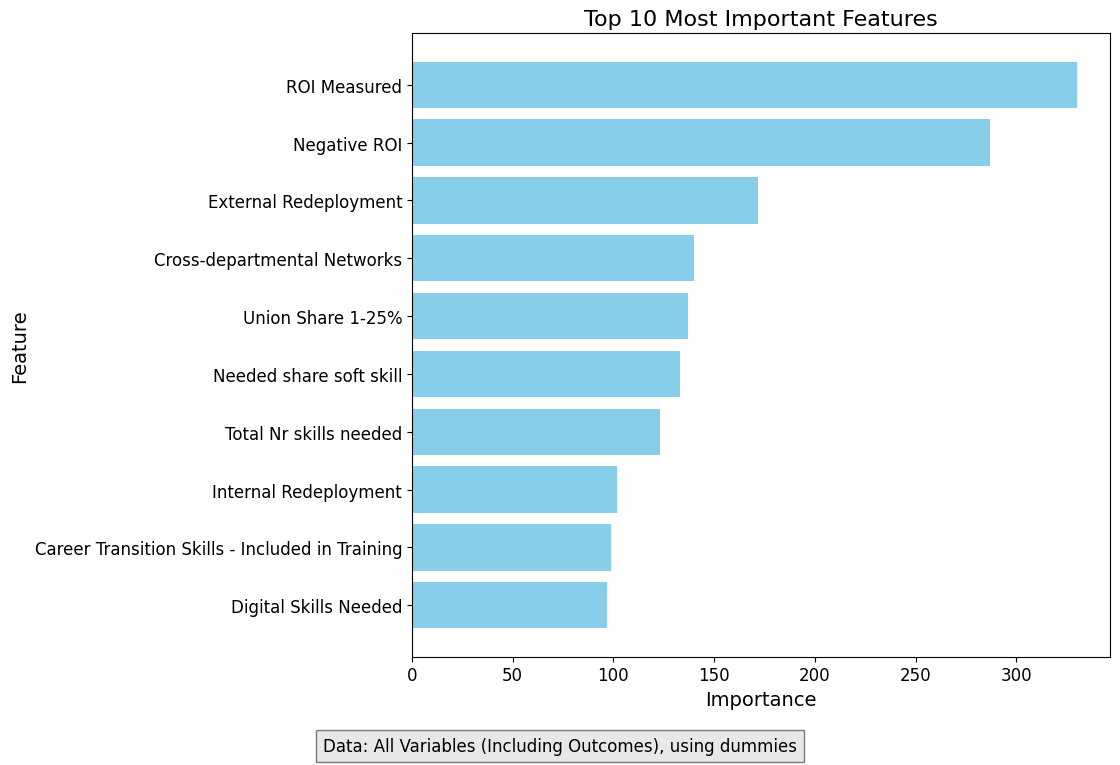

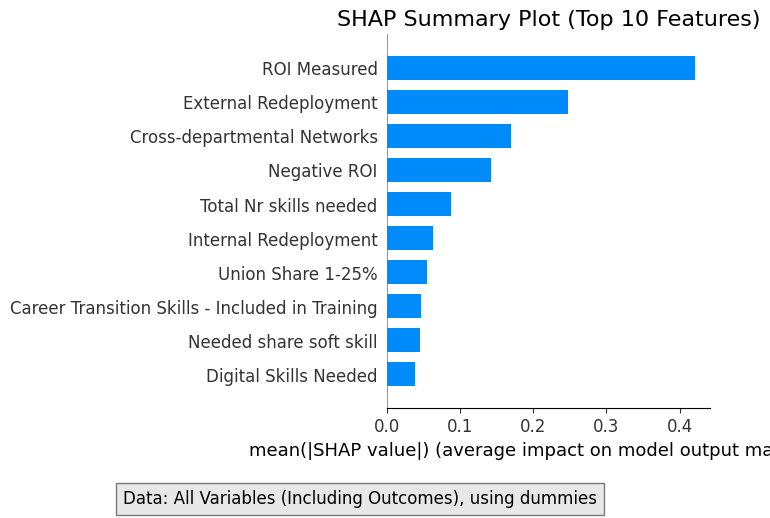

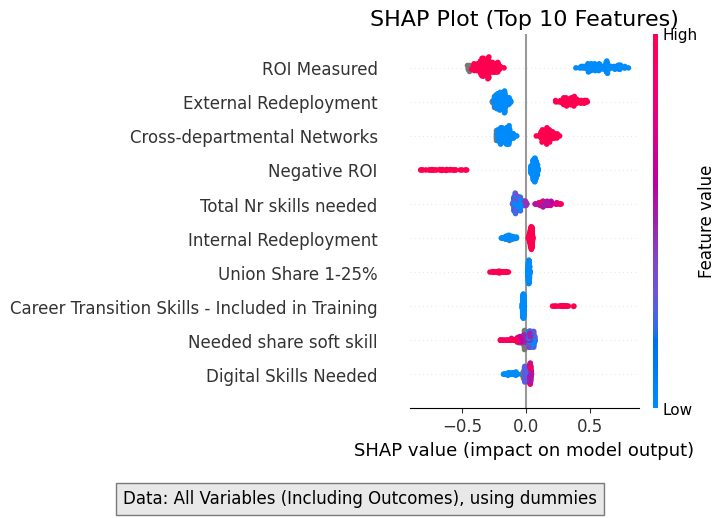

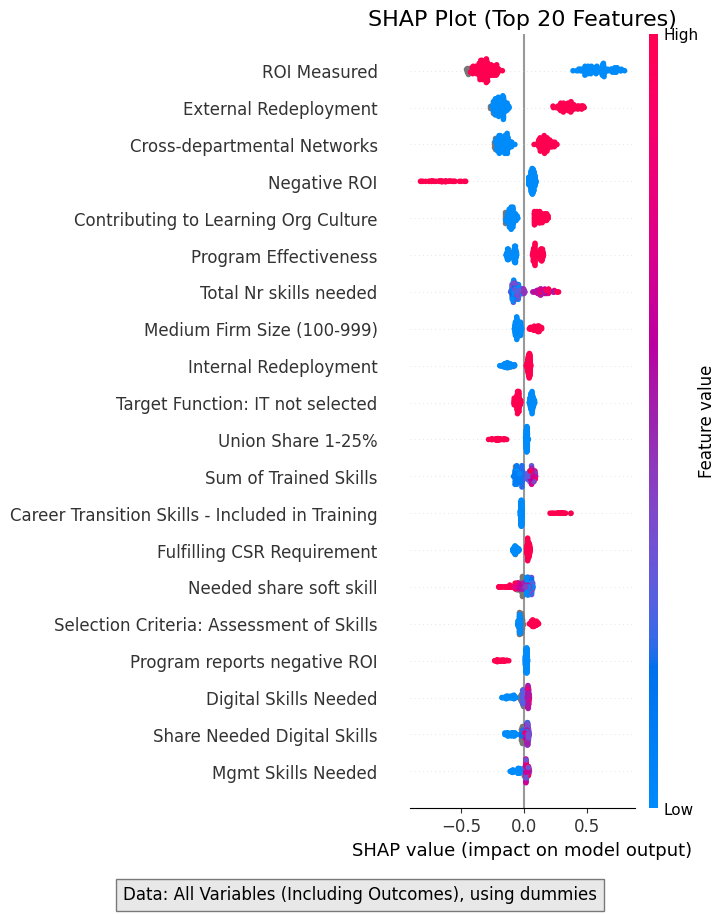

In [6]:
# Preprocess data
preprocessed_data = preprocess_data(data)
target = create_target(data)

# Remove target columns from feature set
X = preprocessed_data.drop(['program_Reskilling', 'program_Upskilling', 'program_General'], axis=1, errors='ignore')
y = target

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost model
model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.005,
    n_estimators=1000,
    min_child_weight=7,
    gamma=0.15,
    subsample=0.65,
    colsample_bytree=0.7,
    reg_lambda=8,
    reg_alpha=2,
    scale_pos_weight=1.45,
    random_state=42,
    eval_metric=['auc', 'logloss']
)

model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Get feature importances and sort them
feature_importance = model.get_booster().get_score(importance_type='weight')
feature_importance = {label_mapping.get(k, k): v for k, v in feature_importance.items()}
sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get top 20 features
top_20_features = sorted_features[:20]
features, importances = zip(*top_20_features)
ordered_feature_names = list(features)

# Plot feature importance with improved formatting - showing only top 10
plt.figure(figsize=(12, 8))  # Increased figure size
plt.barh(list(reversed(ordered_feature_names[:10])), list(reversed(importances[:10])), color='skyblue')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Top 10 Most Important Features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)  # Increased padding
plt.figtext(0.5, 0.01, "Data: All Variables (Including Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/top10_features_all_data.png", dpi=500, bbox_inches='tight')
plt.show()

# Calculate SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_val)

# Create feature name mapping
feature_map = {label_mapping.get(col, col): i for i, col in enumerate(X_val.columns)}

# Find indices of top 20 features
top_feature_indices = []
for feature_name in ordered_feature_names:
    # Try exact match first
    if feature_name in feature_map:
        top_feature_indices.append(feature_map[feature_name])
    else:
        # Fuzzy matching if exact match fails
        best_match = None
        best_score = 0
        for key in feature_map.keys():
            if feature_name in key or key in feature_name:
                score = len(set(feature_name) & set(key))
                if score > best_score:
                    best_score = score
                    best_match = key

        if best_match:
            top_feature_indices.append(feature_map[best_match])
        else:
            print(f"Could not find match for: {feature_name}")

# Filter data for top 20 features
X_val_top20 = X_val.iloc[:, top_feature_indices]
shap_values_top20 = shap_values.values[:, top_feature_indices]

# Create SHAP explanation object with correct ordering
shap_values_top20_obj = shap.Explanation(
    values=shap_values_top20,
    base_values=shap_values.base_values,
    data=X_val_top20.values,
    feature_names=ordered_feature_names
)

# Plot 1: SHAP bar plot with ordered features - top 10 only
plt.figure(figsize=(14, 8))  # Larger figure size
shap.summary_plot(
    shap_values_top20_obj.values[:, :10],
    X_val_top20.iloc[:, :10],
    feature_names=ordered_feature_names[:10],
    plot_type="bar",
    show=False
)
plt.title("SHAP Summary Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)  # Increased padding
plt.figtext(0.5, 0.01, "Data: All Variables (Including Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_summary_top10_ordered.png", dpi=500, bbox_inches='tight')
plt.show()

# Plot 2: SHAP beeswarm plot - top 10 only
plt.figure(figsize=(14, 10))  
shap.summary_plot(
    shap_values_top20_obj.values[:, :10],
    X_val_top20.iloc[:, :10],
    feature_names=ordered_feature_names[:10],
    max_display=10,
    show=False
)
plt.title("SHAP Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)  # Increased padding
plt.figtext(0.5, 0.01, "Data: All Variables (Including Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_beeswarm_top10.png", dpi=500, bbox_inches='tight')
plt.show()

# Plot 3: SHAP beeswarm plot - all 20 features
plt.figure(figsize=(14, 12))  
shap.summary_plot(
    shap_values_top20_obj,
    X_val_top20,
    feature_names=ordered_feature_names,
    max_display=20,
    show=False
)
plt.title("SHAP Plot (Top 20 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)  # Increased padding
plt.figtext(0.5, 0.01, "Data: All Variables (Including Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_beeswarm_top20.png", dpi=500, bbox_inches='tight')
plt.show()

## Analysis 2: Program Characteristics Only (Excluding Outcomes)
This second analysis focuses only on program characteristics, excluding outcome variables, to identify key differentiating features.

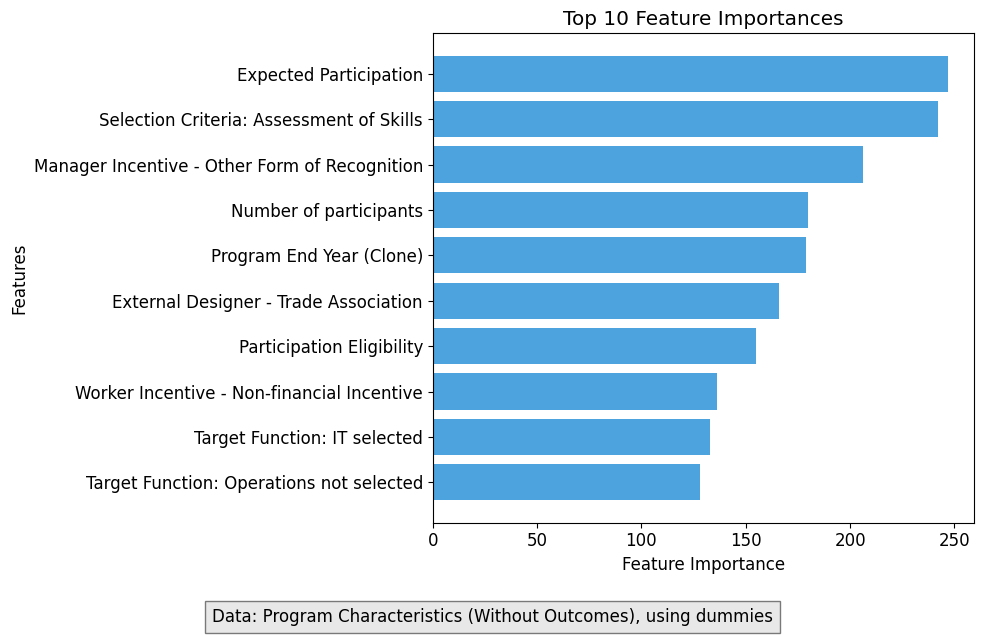

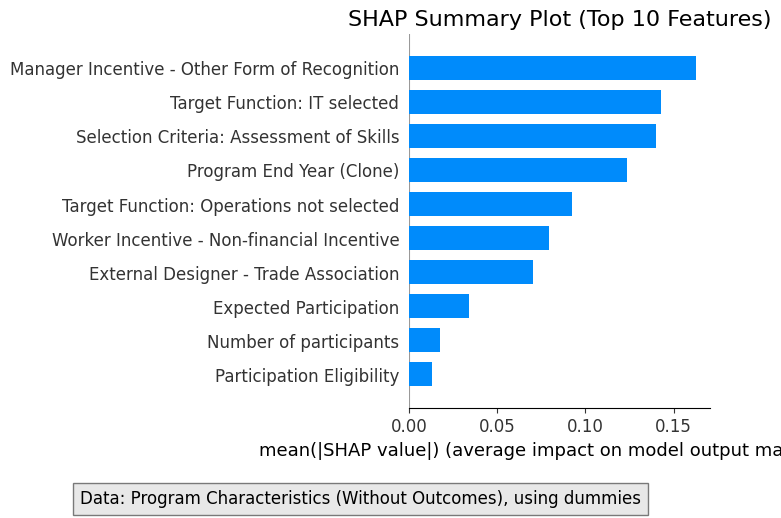

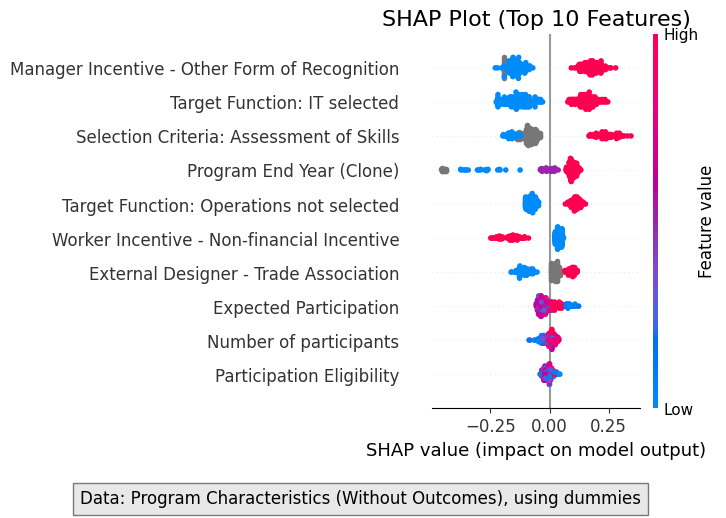

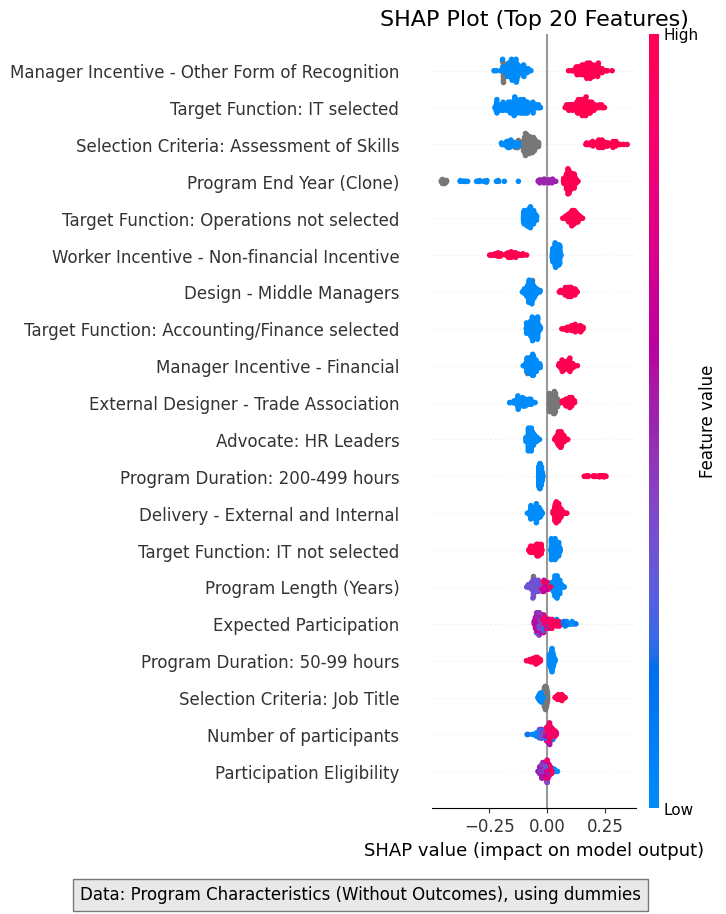

In [7]:
# Create dummy variables
data_dummies = pd.get_dummies(data)

# Clean column names
data_dummies.columns = [col.replace('>', 'greater').replace('<', 'less').replace(',', '_').replace(' ', '_') 
                        for col in data_dummies.columns]
data_dummies = data_dummies.replace({True: 1, False: 0})

# Create target variable
outcomes = [1 if out == 'Reskilling' else 0 for out in data['program']]

# Filter dataset to include only program variables and exclude outcome variables
program_columns = [col for col in data_dummies.columns if any(col.startswith(p) for p in program_variables)]
program_columns = [col for col in program_columns if col not in outcomes_to_exclude]
program_data = data_dummies[program_columns]

# Split data
X_train_prog, X_val_prog, y_train_prog, y_val_prog = train_test_split(
    program_data, outcomes, test_size=0.2, random_state=42, stratify=outcomes
)

# Train XGBoost model on program characteristics only
prog_model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.005,
    n_estimators=1000,
    min_child_weight=7,
    gamma=0.15,
    subsample=0.65,
    colsample_bytree=0.7,
    reg_lambda=8,
    reg_alpha=2,
    scale_pos_weight=1.45,
    random_state=42,
    eval_metric=['auc', 'logloss']
)

prog_model.fit(X_train_prog, y_train_prog, eval_set=[(X_val_prog, y_val_prog)], verbose=False)

# Get feature importances
prog_feature_importance = prog_model.get_booster().get_score(importance_type='weight')
prog_feature_importance = {label_mapping.get(k, k): v for k, v in prog_feature_importance.items()}
prog_sorted_features = sorted(prog_feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get top 20 features instead of just 10
prog_top_20_features = prog_sorted_features[:20]
prog_features, prog_importances = zip(*prog_top_20_features)
ordered_prog_features = list(prog_features)

# Plot top 10 features only
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(ordered_prog_features[:10])), list(reversed(prog_importances[:10])), color='#4CA3DD')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.figtext(0.5, -0.05, "Data: Program Characteristics (Without Outcomes), using dummies", 
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout()
plt.savefig(f"{feature_importance_dir}/top10_features_program_chars.png", dpi=500, bbox_inches='tight')
plt.show()

# Calculate SHAP values for program characteristics
prog_explainer = shap.Explainer(prog_model, X_train_prog)
prog_shap_values = prog_explainer(X_val_prog)

# Create feature name mapping
prog_feature_map = {label_mapping.get(col, col): i for i, col in enumerate(X_val_prog.columns)}

# Find indices of top 20 features
prog_top_feature_indices = []
for feature_name in ordered_prog_features:
    # Try exact match first
    if feature_name in prog_feature_map:
        prog_top_feature_indices.append(prog_feature_map[feature_name])
    else:
        # Fuzzy matching if exact match fails
        best_match = None
        best_score = 0
        for key in prog_feature_map.keys():
            if feature_name in key or key in feature_name:
                score = len(set(feature_name) & set(key))
                if score > best_score:
                    best_score = score
                    best_match = key

        if best_match:
            prog_top_feature_indices.append(prog_feature_map[best_match])
        else:
            print(f"Could not find match for: {feature_name}")

# Filter data for top 20 features
X_val_prog_top20 = X_val_prog.iloc[:, prog_top_feature_indices]
prog_shap_values_top20 = prog_shap_values.values[:, prog_top_feature_indices]

# Create SHAP explanation object with correct ordering
prog_shap_values_top20_obj = shap.Explanation(
    values=prog_shap_values_top20,
    base_values=prog_shap_values.base_values,
    data=X_val_prog_top20.values,
    feature_names=ordered_prog_features
)

# Plot 1: SHAP bar plot with ordered features - top 10 only
plt.figure(figsize=(14, 8))
shap.summary_plot(
    prog_shap_values_top20_obj.values[:, :10],
    X_val_prog_top20.iloc[:, :10],
    feature_names=ordered_prog_features[:10],
    plot_type="bar",
    show=False
)
plt.title("SHAP Summary Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: Program Characteristics (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_summary_top10_program_chars.png", dpi=500, bbox_inches='tight')
plt.show()

# Plot 2: SHAP beeswarm plot - top 10 only
plt.figure(figsize=(14, 10))
shap.summary_plot(
    prog_shap_values_top20_obj.values[:, :10],
    X_val_prog_top20.iloc[:, :10],
    feature_names=ordered_prog_features[:10],
    max_display=10,
    show=False
)
plt.title("SHAP Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: Program Characteristics (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_beeswarm_top10_program_chars.png", dpi=500, bbox_inches='tight')
plt.show()

# Plot 3: SHAP beeswarm plot - all 20 features
plt.figure(figsize=(14, 12))  
shap.summary_plot(
    prog_shap_values_top20_obj,
    X_val_prog_top20,
    feature_names=ordered_prog_features,
    max_display=20,
    show=False
)
plt.title("SHAP Plot (Top 20 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: Program Characteristics (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_beeswarm_top20_program_chars.png", dpi=500, bbox_inches='tight')
plt.show()

## Analysis 3: Program Characteristics with Original Categorical Variables (No Dummies)
This analysis preserves the categorical nature of variables without converting to dummies


Features used in model training:
['p_participated', 'p_participated_2023', 'p_mandavolunt', 'p_year_start', 'p_year_end', 'p_year_start_clone2', 'p_year_end_clone2', 'p_ongoing', 'p_program_length', 'p_hourstrained', 'p_duration', 'p_comphours', 'p_otjactivities', 'p_cost', 'p_advocacy', 'p_advocacy_hier', 'p_responsibility', 'p_responsibility_hier', 'p_application', 'p_selection', 'p_criteria_jobtitle', 'p_criteria_tenure', 'p_criteria_qualifications', 'p_criteria_assmskills', 'p_criteria_assmsmotivation', 'p_criteria_managerrec', 'p_criteria_other', 'p_targetemp_c', 'p_targetemp_bul', 'p_targetemp_mm', 'p_targetemp_emp', 'p_targetfunc_leg', 'p_targetfunc_hr', 'p_targetfunc_adm', 'p_targetfunc_it', 'p_targetfunc_op', 'p_targetfunc_mrksal', 'p_targetfunc_rd', 'p_targetfunc_accfin', 'p_targetfunc_cust', 'p_difloc', 'p_difstand', 'p_eligibility', 'p_part', 'p_part_exp', 'dd_pilot_length', 'dd_pilot_dummy', 'dd_pilot_ct', 'dd_pilot_over', 'dd_design_board', 'dd_design_c', 'dd_design_hr', 

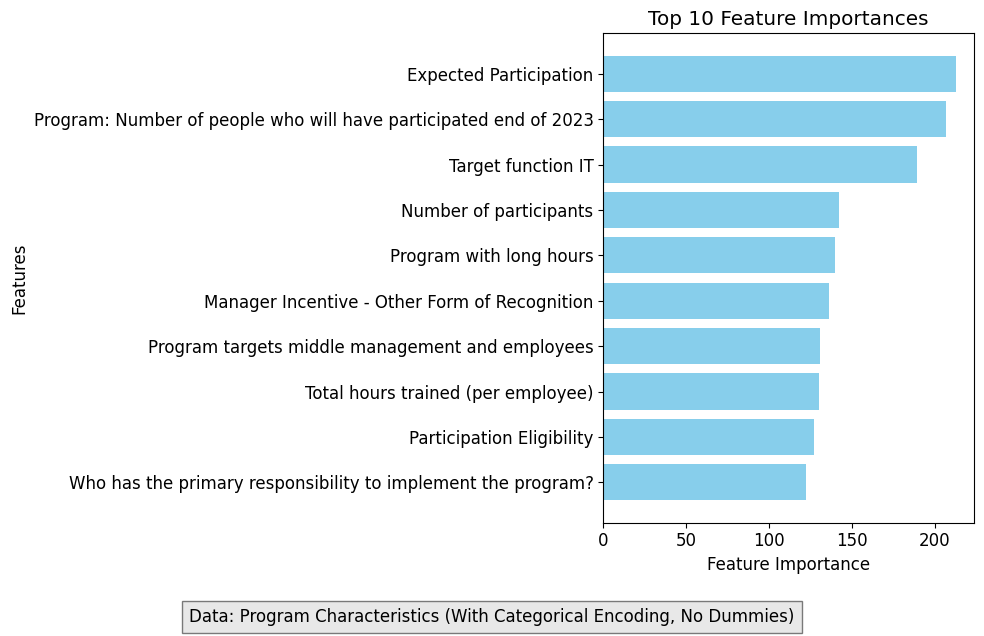

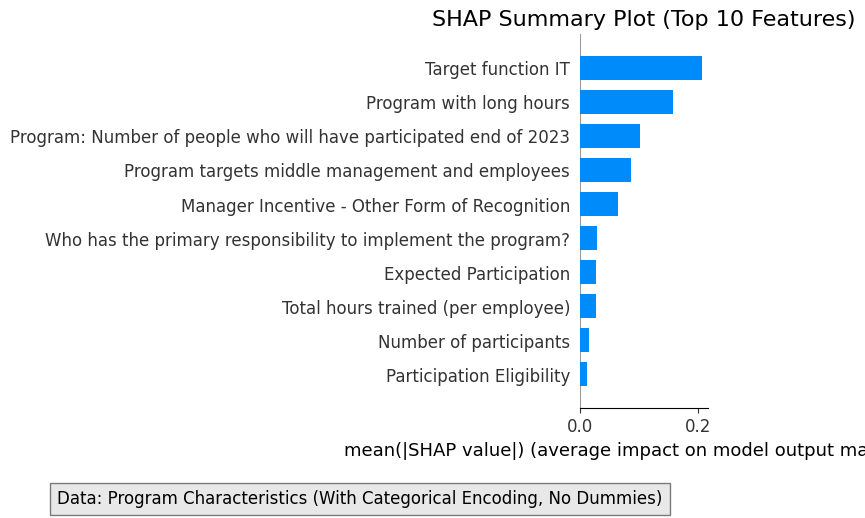

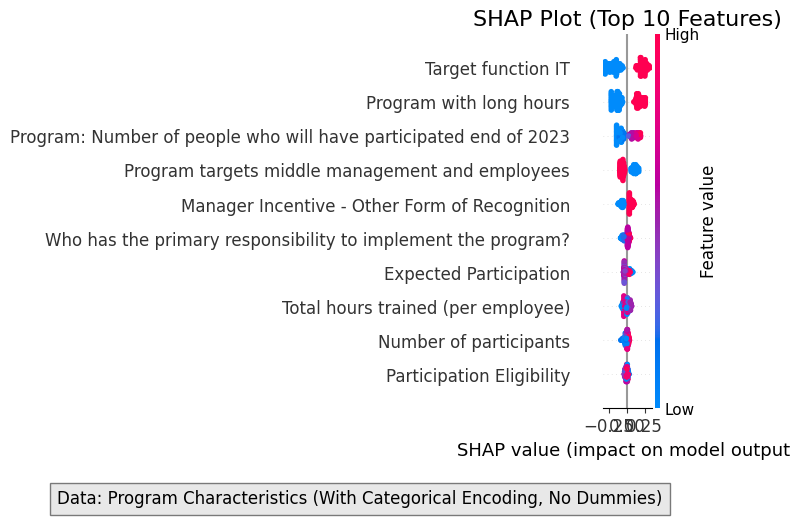

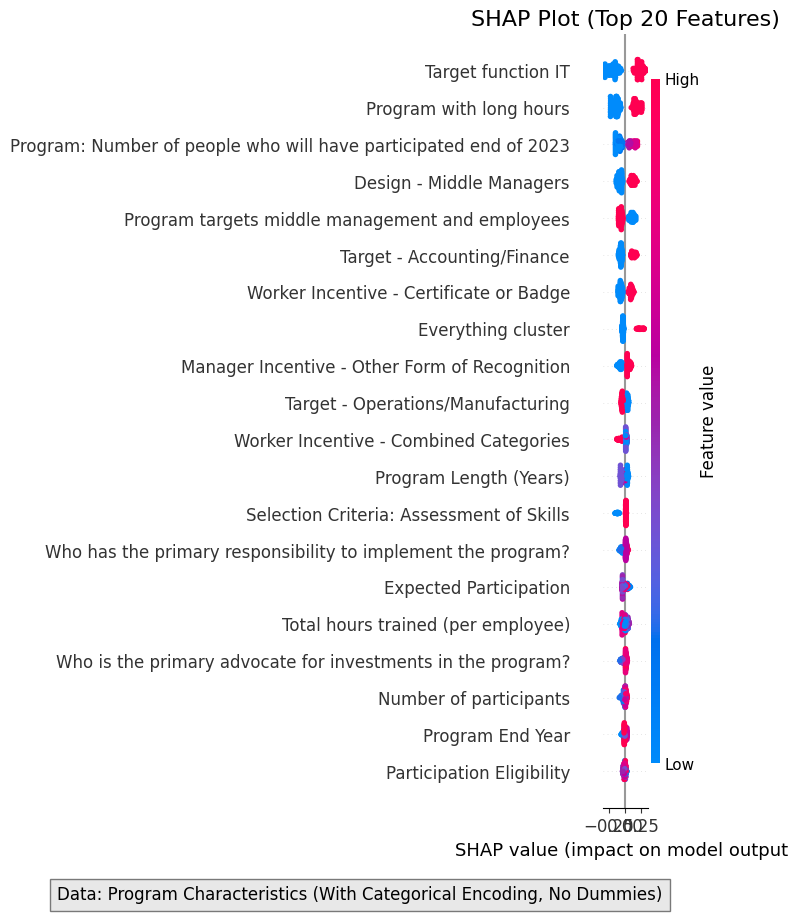

In [8]:
# Filter to select only program-specific variables
program_cols = [col for col in data.columns if any(col.startswith(p.split('_')[0]) for p in program_variables)]
program_data_original = data[program_cols].copy()

# Exclude outcome variables AND the target variable and closely related variables
program_data_original = program_data_original[[col for col in program_data_original.columns 
                                             if col not in outcomes_to_exclude 
                                             and col != 'program'
                                             and 'program type' not in col.lower()]]

# Handle missing values
for col in program_data_original.columns:
    if program_data_original[col].dtype == 'object' or program_data_original[col].dtype.name == 'category':
        # For object/categorical columns, fill with the most common value
        if not program_data_original[col].mode().empty:
            program_data_original[col] = program_data_original[col].fillna(program_data_original[col].mode()[0])
    else:
        # For numeric columns, fill with median
        program_data_original[col] = program_data_original[col].fillna(program_data_original[col].median())

# Create target variable
cat_target = data['program'].copy()
target_encoded = np.where(cat_target == 'Reskilling', 1, 0)

# Encode categorical variables using label encoding
from sklearn.preprocessing import LabelEncoder
categorical_cols = program_data_original.select_dtypes(include=['object', 'category']).columns

# Create a label encoder for each categorical column
encoded_data = program_data_original.copy()
for col in categorical_cols:
    le = LabelEncoder()
    # Fit and transform in one step
    encoded_data[col] = le.fit_transform(program_data_original[col].astype(str))

# Print feature names to verify we're excluding the target variable
print("Features used in model training:")
print(encoded_data.columns.tolist())
print(f"\nTotal number of features: {encoded_data.shape[1]}")

# Split data
X_train_cat, X_val_cat, y_train_cat, y_val_cat = train_test_split(
    encoded_data, target_encoded, test_size=0.2, random_state=42, stratify=target_encoded
)

# Train model with the same parameters for consistency
cat_model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.005,
    n_estimators=1000,
    min_child_weight=7,
    gamma=0.15,
    subsample=0.65,
    colsample_bytree=0.7,
    reg_lambda=8,
    reg_alpha=2,
    scale_pos_weight=1.45,
    random_state=42,
    eval_metric=['auc', 'logloss']
)

cat_model.fit(X_train_cat, y_train_cat, eval_set=[(X_val_cat, y_val_cat)], verbose=False)

# Get feature importances
cat_feature_importance = cat_model.get_booster().get_score(importance_type='weight')
cat_feature_importance = {label_mapping.get(k, k): v for k, v in cat_feature_importance.items()}
cat_sorted_features = sorted(cat_feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get top 20 features instead of just 10
cat_top_20_features = cat_sorted_features[:20]
cat_features, cat_importances = zip(*cat_top_20_features)
ordered_cat_features = list(cat_features)

# Plot top 10 features only
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(ordered_cat_features[:10])), list(reversed(cat_importances[:10])), color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances')
plt.figtext(0.5, -0.05, "Data: Program Characteristics (With Categorical Encoding, No Dummies)", 
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout()
plt.savefig(f"{feature_importance_dir}/top10_features_program_categorical.png", dpi=500, bbox_inches='tight')
plt.show()

# Calculate SHAP values
cat_explainer = shap.Explainer(cat_model, X_train_cat)
cat_shap_values = cat_explainer(X_val_cat)

# Create feature name mapping
cat_feature_map = {label_mapping.get(col, col): i for i, col in enumerate(X_val_cat.columns)}

# Find indices of top 20 features
cat_top_feature_indices = []
for feature_name in ordered_cat_features:
    # Try exact match first
    if feature_name in cat_feature_map:
        cat_top_feature_indices.append(cat_feature_map[feature_name])
    else:
        # Fuzzy matching if exact match fails
        best_match = None
        best_score = 0
        for key in cat_feature_map.keys():
            if feature_name in key or key in feature_name:
                score = len(set(feature_name) & set(key))
                if score > best_score:
                    best_score = score
                    best_match = key

        if best_match:
            cat_top_feature_indices.append(cat_feature_map[best_match])
        else:
            print(f"Could not find match for: {feature_name}")

# Filter data for top 20 features
X_val_cat_top20 = X_val_cat.iloc[:, cat_top_feature_indices]
cat_shap_values_top20 = cat_shap_values.values[:, cat_top_feature_indices]

# Create SHAP explanation object with correct ordering
cat_shap_values_top20_obj = shap.Explanation(
    values=cat_shap_values_top20,
    base_values=cat_shap_values.base_values,
    data=X_val_cat_top20.values,
    feature_names=ordered_cat_features
)

# Plot 1: SHAP bar plot with ordered features - top 10 only
plt.figure(figsize=(14, 8))
shap.summary_plot(
    cat_shap_values_top20_obj.values[:, :10],
    X_val_cat_top20.iloc[:, :10],
    feature_names=ordered_cat_features[:10],
    plot_type="bar",
    show=False
)
plt.title("SHAP Summary Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: Program Characteristics (With Categorical Encoding, No Dummies)",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_summary_top10_categorical.png", dpi=500, bbox_inches='tight')
plt.show()

# Plot 2: SHAP beeswarm plot - top 10 only
plt.figure(figsize=(14, 10))
shap.summary_plot(
    cat_shap_values_top20_obj.values[:, :10],
    X_val_cat_top20.iloc[:, :10],
    feature_names=ordered_cat_features[:10],
    max_display=10,
    show=False
)
plt.title("SHAP Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: Program Characteristics (With Categorical Encoding, No Dummies)",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_beeswarm_top10_categorical.png", dpi=500, bbox_inches='tight')
plt.show()

# Plot 3: SHAP beeswarm plot - all 20 features
plt.figure(figsize=(14, 12))  
shap.summary_plot(
    cat_shap_values_top20_obj,
    X_val_cat_top20,
    feature_names=ordered_cat_features,
    max_display=20,
    show=False
)
plt.title("SHAP Plot (Top 20 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: Program Characteristics (With Categorical Encoding, No Dummies)",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_beeswarm_top20_categorical.png", dpi=500, bbox_inches='tight')
plt.show()

## Analysis 4: All Variables Without Outcomes (Using Dummies)
This analysis uses all variables except outcome variables, with dummy encoding to identify key differentiating features between upskilling and reskilling programs.

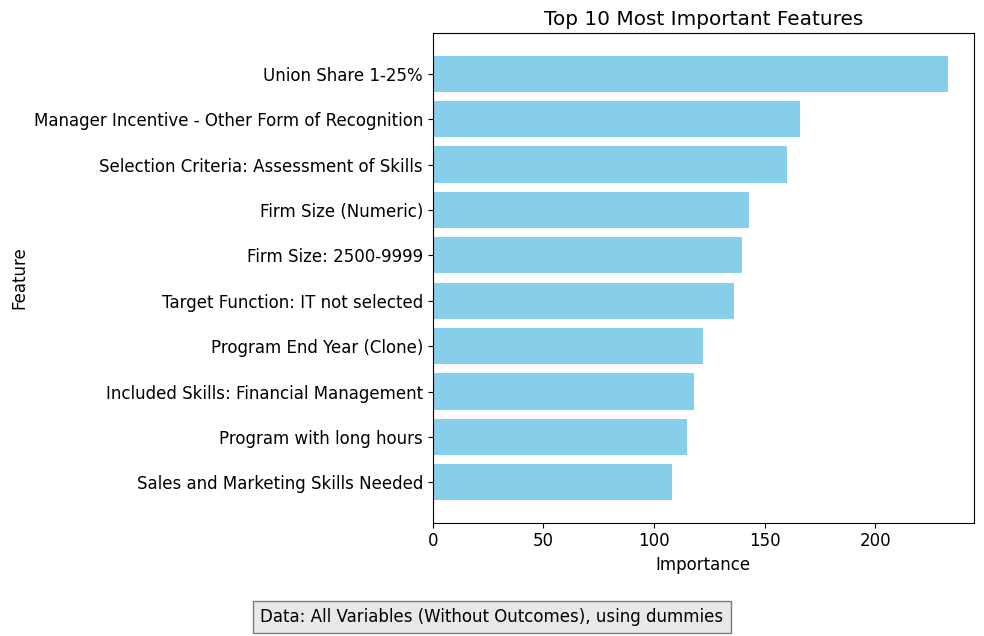

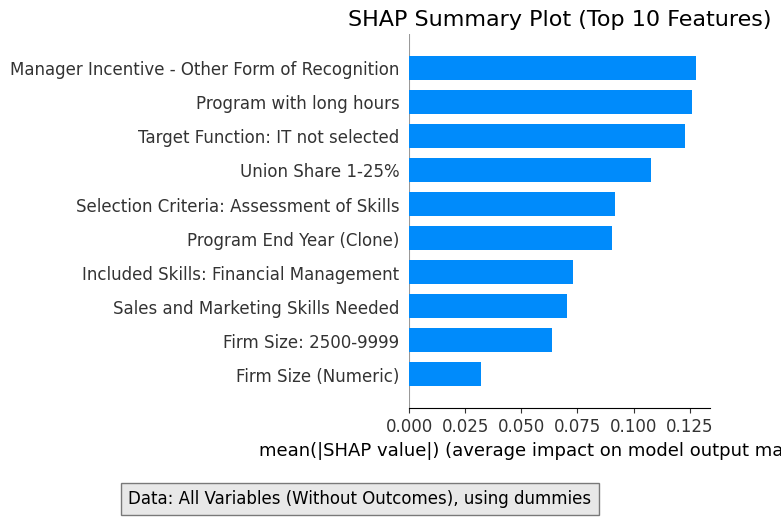

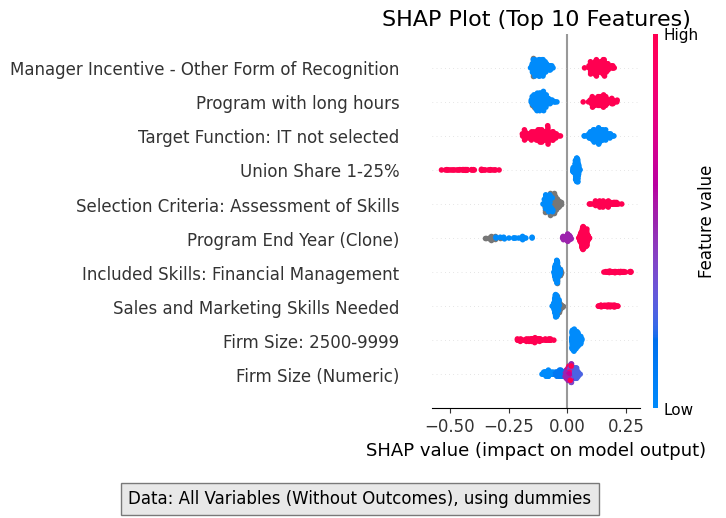

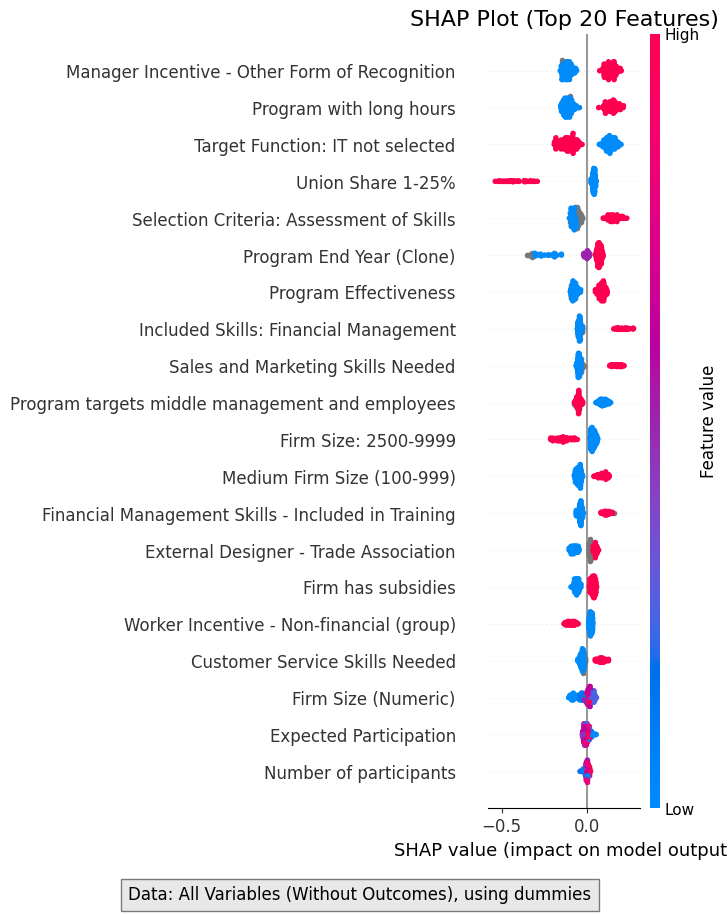

In [9]:
# Create a copy of the data to work with
all_data_no_outcomes = preprocess_data(data)

# Create target variable - Reskilling = 1, Upskilling = 0
target_all_no_outcomes = create_target(data)

# Remove target columns from feature set
X_all_no_out = all_data_no_outcomes.drop(['program_Reskilling', 'program_Upskilling', 'program_General'], axis=1, errors='ignore')

# Now remove outcome variables using the updated outcomes_to_exclude list
outcome_columns = [col for col in X_all_no_out.columns if any(out in col for out in outcomes_to_exclude)]
X_all_no_out = X_all_no_out.drop(outcome_columns, axis=1, errors='ignore')

# Also remove any challenge-related variables
challenge_columns = [col for col in X_all_no_out.columns if 'challenge' in col.lower() or 'cha_' in col.lower()]
X_all_no_out = X_all_no_out.drop(challenge_columns, axis=1, errors='ignore')

# Filter for only program variables and firm characteristics
program_cols = [col for col in X_all_no_out.columns if any(col.startswith(p.split('_')[0]) for p in program_variables)]
firm_cols = [col for col in X_all_no_out.columns if col.startswith('f_') or 
             col.startswith('sk_n_f_') or col.startswith('tr_sk_n_f_')]

# Combine program and firm characteristics
X_all_no_out = X_all_no_out[program_cols + firm_cols]
y_all_no_out = target_all_no_outcomes

# Split the data
X_train_all_no_out, X_val_all_no_out, y_train_all_no_out, y_val_all_no_out = train_test_split(
    X_all_no_out, y_all_no_out, test_size=0.2, random_state=42, stratify=y_all_no_out
)

# Train XGBoost model
all_no_out_model = xgb.XGBClassifier(
    max_depth=3,
    learning_rate=0.005,
    n_estimators=1000,
    min_child_weight=7,
    gamma=0.15,
    subsample=0.65,
    colsample_bytree=0.7,
    reg_lambda=8,
    reg_alpha=2,
    scale_pos_weight=1.45,
    random_state=42,
    eval_metric=['auc', 'logloss']
)

all_no_out_model.fit(X_train_all_no_out, y_train_all_no_out, 
                    eval_set=[(X_val_all_no_out, y_val_all_no_out)], 
                    verbose=False)

# Get feature importances and sort them
all_no_out_importance = all_no_out_model.get_booster().get_score(importance_type='weight')
all_no_out_importance = {label_mapping.get(k, k): v for k, v in all_no_out_importance.items()}
all_no_out_sorted = sorted(all_no_out_importance.items(), key=lambda x: x[1], reverse=True)

# Get top 20 features
all_no_out_top_20 = all_no_out_sorted[:20]
all_no_out_features, all_no_out_importances = zip(*all_no_out_top_20)
ordered_all_no_out_features = list(all_no_out_features)

# Plot feature importance with top 10 only
plt.figure(figsize=(10, 6))
plt.barh(list(reversed(ordered_all_no_out_features[:10])), list(reversed(all_no_out_importances[:10])), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.figtext(0.5, -0.05, "Data: All Variables (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout()
plt.savefig(f"{feature_importance_dir}/top10_features_all_data_no_outcomes.png", dpi=500, bbox_inches='tight')
plt.show()

# Calculate SHAP values
all_no_out_explainer = shap.Explainer(all_no_out_model, X_train_all_no_out)
all_no_out_shap_values = all_no_out_explainer(X_val_all_no_out)

# Create feature name mapping
all_no_out_feature_map = {label_mapping.get(col, col): i for i, col in enumerate(X_val_all_no_out.columns)}

# Find indices of top 20 features
all_no_out_top_indices = []
for feature_name in ordered_all_no_out_features:
    # Try exact match first
    if feature_name in all_no_out_feature_map:
        all_no_out_top_indices.append(all_no_out_feature_map[feature_name])
    else:
        # Fuzzy matching if exact match fails
        best_match = None
        best_score = 0
        for key in all_no_out_feature_map.keys():
            if feature_name in key or key in feature_name:
                score = len(set(feature_name) & set(key))
                if score > best_score:
                    best_score = score
                    best_match = key

        if best_match:
            all_no_out_top_indices.append(all_no_out_feature_map[best_match])
        else:
            print(f"Could not find match for: {feature_name}")

# Filter data for top 20 features
X_val_all_no_out_top20 = X_val_all_no_out.iloc[:, all_no_out_top_indices]
all_no_out_shap_top20 = all_no_out_shap_values.values[:, all_no_out_top_indices]

# Create SHAP explanation object with correct ordering
all_no_out_shap_top20_obj = shap.Explanation(
    values=all_no_out_shap_top20,
    base_values=all_no_out_shap_values.base_values,
    data=X_val_all_no_out_top20.values,
    feature_names=ordered_all_no_out_features
)

# Plot 1: SHAP bar plot with ordered features - top 10 only
plt.figure(figsize=(14, 8))
shap.summary_plot(
    all_no_out_shap_top20_obj.values[:, :10],
    X_val_all_no_out_top20.iloc[:, :10],
    feature_names=ordered_all_no_out_features[:10],
    plot_type="bar",
    show=False
)
plt.title("SHAP Summary Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: All Variables (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_summary_top10_all_no_outcomes.png", dpi=500, bbox_inches='tight')
plt.show()

# Plot 2: SHAP beeswarm plot - top 10 only
plt.figure(figsize=(14, 10))
shap.summary_plot(
    all_no_out_shap_top20_obj.values[:, :10],
    X_val_all_no_out_top20.iloc[:, :10],
    feature_names=ordered_all_no_out_features[:10],
    max_display=10,
    show=False
)
plt.title("SHAP Plot (Top 10 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: All Variables (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_beeswarm_top10_all_no_outcomes.png", dpi=500, bbox_inches='tight')
plt.show()

# Plot 3: SHAP beeswarm plot - all 20 features
plt.figure(figsize=(14, 12))  
shap.summary_plot(
    all_no_out_shap_top20_obj,
    X_val_all_no_out_top20,
    feature_names=ordered_all_no_out_features,
    max_display=20,
    show=False
)
plt.title("SHAP Plot (Top 20 Features)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=3.0)
plt.figtext(0.5, 0.01, "Data: All Variables (Without Outcomes), using dummies",
           ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.savefig(f"{feature_importance_dir}/shap_beeswarm_top20_all_no_outcomes.png", dpi=500, bbox_inches='tight')
plt.show()

## Appendix: Additional Model Results
This appendix compares the results of the four modeling approaches:
1. All variables (including outcomes)
2. Only program features (with dummies)
3. Program features with categorical encoding (without dummies)
4. All variables without outcomes (with dummies)

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix
)
from matplotlib.gridspec import GridSpec
import seaborn as sns
import os

# List of models, names, and validation datasets
models = [model, prog_model, cat_model, all_no_out_model]
model_names = [
    "All variables (with outcomes)",
    "Program features (with dummies)",
    "Program features (with categorical encoding)",
    "All variables without outcomes"
]

# Ensure validation sets have same features as training sets
# This fixes the feature_names mismatch error
def align_features(model, X_val):
    try:
        # If using XGBoost model with get_booster() available
        features = model.get_booster().feature_names
        if features is not None:
            # Ensure X_val has the same features in the same order
            missing_cols = set(features) - set(X_val.columns)
            for col in missing_cols:
                X_val[col] = 0  # Add missing columns with default value
            return X_val[features]  # Return with aligned features
    except:
        pass
    
    # Fallback if above method doesn't work
    return X_val

# Align all validation sets with their respective models
X_val_aligned = align_features(model, X_val)
X_val_prog_aligned = align_features(prog_model, X_val_prog)
X_val_cat_aligned = align_features(cat_model, X_val_cat)
X_val_all_no_out_aligned = align_features(all_no_out_model, X_val_all_no_out)

# Update validation sets with aligned features
val_sets = [
    (X_val_aligned, y_val),
    (X_val_prog_aligned, y_val_prog),
    (X_val_cat_aligned, y_val_cat),
    (X_val_all_no_out_aligned, y_val_all_no_out)
]

# 1. Performance metrics table - Export to file instead of terminal output
metrics_data = []

for i, (model, name, (X_val_set, y_val_set)) in enumerate(zip(models, model_names, val_sets)):
    # Predict using the aligned validation data
    y_pred = model.predict(X_val_set)
    y_pred_proba = model.predict_proba(X_val_set)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_val_set, y_pred)
    precision = precision_score(y_val_set, y_pred)
    recall = recall_score(y_val_set, y_pred)
    f1 = f1_score(y_val_set, y_pred)
    auc = roc_auc_score(y_val_set, y_pred_proba)

    # Save for plots and export
    metrics_data.append({
        'model_id': i+1,
        'model_name': name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    })

# Create DataFrame and export to CSV
metrics_df = pd.DataFrame(metrics_data)
metrics_df.to_csv(f"{stats_dir}/model_performance_metrics.csv", index=False)
print(f"Model performance metrics exported to {stats_dir}/model_performance_metrics.csv")

# Also export a formatted version for reporting
with open(f"{reports_dir}/model_performance_summary.md", "w") as f:
    f.write("# Model Performance Summary\n\n")
    f.write("| Model | Accuracy | Precision | Recall | F1 | AUC |\n")
    f.write("|-------|----------|-----------|--------|----|---------|\n")
    
    for _, row in metrics_df.iterrows():
        f.write(f"| Model {row['model_id']}: {row['model_name']} | {row['accuracy']:.4f} | {row['precision']:.4f} | {row['recall']:.4f} | {row['f1']:.4f} | {row['auc']:.4f} |\n")

# 2. Comparative visualization of metrics
plt.figure(figsize=(15, 10))
metrics_to_plot = ['accuracy', 'precision', 'recall', 'f1', 'auc']
colors = ['#3366cc', '#dc3912', '#ff9900', '#109618', '#990099']

# Create subplots
for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 3, i+1)
    bars = plt.bar(range(len(model_names)), metrics_df[metric], color=colors[i])
    plt.title(f'{metric.capitalize()}', fontsize=14)
    plt.xticks(range(len(model_names)), [f'Model {i+1}' for i in range(len(model_names))], rotation=45)
    plt.ylim([0, 1])

    # Add values on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', fontsize=9)

plt.figtext(0.5, 0.01, "Comparison of metrics among the four models",
           ha='center', fontsize=14, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig(f"{model_comparisons_dir}/metrics_comparison.png", dpi=500, bbox_inches='tight')
plt.close()

# 3. ROC curves for all models
plt.figure(figsize=(10, 8))
for i, (model, name, (X_val_set, y_val_set)) in enumerate(zip(models, model_names, val_sets)):
    y_pred_proba = model.predict_proba(X_val_set)[:, 1]
    fpr, tpr, _ = roc_curve(y_val_set, y_pred_proba)
    auc = roc_auc_score(y_val_set, y_pred_proba)
    plt.plot(fpr, tpr, linewidth=2, label=f'Model {i+1} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves for the Four Models', fontsize=14)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.savefig(f"{model_comparisons_dir}/roc_curves_comparison.png", dpi=500, bbox_inches='tight')
plt.close()

# 4. Confusion matrices for each model
fig = plt.figure(figsize=(18, 5))
confusion_matrices = []

for i, (model, name, (X_val_set, y_val_set)) in enumerate(zip(models, model_names, val_sets)):
    y_pred = model.predict(X_val_set)
    cm = confusion_matrix(y_val_set, y_pred)
    confusion_matrices.append(cm)
    
    plt.subplot(1, 4, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Model {i+1}\n{name}', fontsize=11)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')

plt.tight_layout()
plt.savefig(f"{model_comparisons_dir}/confusion_matrices.png", dpi=500, bbox_inches='tight')
plt.close()

# Save confusion matrices to CSV
for i, cm in enumerate(confusion_matrices):
    pd.DataFrame(cm, columns=['Predicted 0', 'Predicted 1'], 
                index=['Actual 0', 'Actual 1']).to_csv(
                f"{stats_dir}/confusion_matrix_model_{i+1}.csv")

# 5. Top 25 most important features (expansion of top 10)
# For the best-performing model
best_model_idx = metrics_df['auc'].argmax()
best_model = models[best_model_idx]
best_model_name = model_names[best_model_idx]
X_val_best = val_sets[best_model_idx][0]

# Get feature importances from the best model safely
try:
    feature_importance = best_model.get_booster().get_score(importance_type='weight')
    feature_importance = {label_mapping.get(k, k): v for k, v in feature_importance.items()}
    sorted_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    top_25_features = sorted_features[:25]
    features, importances = zip(*top_25_features)
    
    # Export feature importance to CSV
    feature_importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': importances
    })
    feature_importance_df.to_csv(f"{stats_dir}/top_features_best_model.csv", index=False)
    
    # Visualization
    plt.figure(figsize=(12, 14))
    plt.barh(list(reversed(features)), list(reversed(importances)), color='skyblue')
    plt.xlabel('Importance', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.title(f'Top 25 Most Important Features\nModel: {best_model_name}', fontsize=16)
    plt.figtext(0.5, 0.01, "Expansion of the analysis to 25 main features",
               ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    plt.savefig(f"{feature_importance_dir}/top25_features_best_model.png", dpi=500, bbox_inches='tight')
    plt.close()
except Exception as e:
    print(f"Could not generate feature importance plot: {str(e)}")
    # Try alternative method if the first one fails
    try:
        if hasattr(best_model, 'feature_importances_'):
            # Get feature names from validation data
            feature_names = X_val_best.columns
            importances = best_model.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            # Top 25 features
            top_indices = indices[:25]
            top_features = [feature_names[i] for i in top_indices]
            top_importances = [importances[i] for i in top_indices]
            
            # Export feature importance to CSV
            feature_importance_df = pd.DataFrame({
                'Feature': top_features,
                'Importance': top_importances
            })
            feature_importance_df.to_csv(f"{stats_dir}/top_features_best_model.csv", index=False)
            
            # Visualization
            plt.figure(figsize=(12, 14))
            plt.barh(list(reversed(top_features)), list(reversed(top_importances)), color='skyblue')
            plt.xlabel('Importance', fontsize=14)
            plt.ylabel('Feature', fontsize=14)
            plt.title(f'Top 25 Most Important Features\nModel: {best_model_name}', fontsize=16)
            plt.figtext(0.5, 0.01, "Expansion of the analysis to 25 main features",
                      ha='center', fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})
            plt.tight_layout(rect=[0, 0.03, 1, 0.97])
            plt.savefig(f"{feature_importance_dir}/top25_features_best_model.png", dpi=500, bbox_inches='tight')
            plt.close()
    except Exception as e:
        print(f"Could not generate feature importance using alternative method: {str(e)}")

# 6. Analysis of specific categories:
# Correctly classified cases vs incorrectly classified cases
best_X_val = val_sets[best_model_idx][0]
best_y_val = val_sets[best_model_idx][1]
best_y_pred = best_model.predict(best_X_val)

# Identify correct and incorrect cases
correct_indices = best_y_val == best_y_pred
incorrect_indices = ~correct_indices

# Calculate summary statistics for misclassifications
total_samples = len(best_y_val)
correct_count = sum(correct_indices)
incorrect_count = sum(incorrect_indices)
correct_percent = correct_count/total_samples*100
incorrect_percent = incorrect_count/total_samples*100

# Export misclassification analysis to file
misclassification_summary = {
    'Total Samples': [total_samples],
    'Correct Classifications': [correct_count],
    'Correct Classifications (%)': [correct_percent],
    'Incorrect Classifications': [incorrect_count],
    'Incorrect Classifications (%)': [incorrect_percent]
}
pd.DataFrame(misclassification_summary).to_csv(f"{stats_dir}/misclassification_summary.csv", index=False)

# Calculate predicted probabilities for misclassified samples
best_y_pred_proba = best_model.predict_proba(best_X_val)[:, 1]
incorrect_probas = best_y_pred_proba[incorrect_indices]

# Export probabilities of misclassifications
if len(incorrect_probas) > 0:
    pd.DataFrame({'Probability': incorrect_probas}).to_csv(f"{stats_dir}/misclassification_probabilities.csv", index=False)
    
    # Histogram of probabilities for misclassifications
    plt.figure(figsize=(10, 6))
    plt.hist(incorrect_probas, bins=20, alpha=0.7, color='crimson')
    plt.axvline(x=0.5, color='black', linestyle='--', linewidth=1)
    plt.xlabel('Predicted Probability for Positive Class (Reskilling)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.title('Distribution of Probabilities for Misclassifications', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"{feature_importance_dir}/incorrect_classifications_proba_dist.png", dpi=500, bbox_inches='tight')
    plt.close()

# 7. Conclusions and final report
# Identify the best model based on AUC
best_model_name = model_names[metrics_df['auc'].argmax()]

# Compare the use of categorical variables vs dummies
cat_idx = 2  # Index of the categorical model
dummy_idx = 1  # Index of the model with dummies
cat_auc = metrics_df.iloc[cat_idx]['auc']
dummy_auc = metrics_df.iloc[dummy_idx]['auc']
comparison = "better" if cat_auc > dummy_auc else "worse"

# Analyze the impact of including outcome variables
outcome_idx = 0  # Index of the model with outcome variables
no_outcome_idx = 3  # Index of the model without outcome variables
outcome_auc = metrics_df.iloc[outcome_idx]['auc']
no_outcome_auc = metrics_df.iloc[no_outcome_idx]['auc']
outcome_impact = "improvement" if outcome_auc > no_outcome_auc else "deterioration"

# Generate final report in markdown format
with open(f"{reports_dir}/conclusion_report.md", "w") as f:
    f.write("# Feature Importance Analysis: Conclusions\n\n")
    f.write("## Key Findings\n\n")
    f.write(f"- The model with the best overall performance (AUC) is: **{best_model_name}**\n\n")
    f.write(f"- The use of categorical variables with encoding resulted in a **{comparison}** performance than using dummies:\n")
    f.write(f"  - AUC with categorical encoding: {cat_auc:.4f}\n")
    f.write(f"  - AUC with dummies: {dummy_auc:.4f}\n\n")
    f.write(f"- Including outcome variables results in an **{outcome_impact}** of the model:\n")
    f.write(f"  - AUC with outcome variables: {outcome_auc:.4f}\n")
    f.write(f"  - AUC without outcome variables: {no_outcome_auc:.4f}\n\n")
    f.write("This analysis demonstrates the importance of feature selection and categorical variable encoding ")
    f.write("in model performance for distinguishing between Upskilling and Reskilling programs.\n\n")
    
    # Add top features if available
    try:
        if 'sorted_features' in locals() and len(sorted_features) > 0:
            f.write("## Top Features\n\n")
            f.write("The top 5 most important features for distinguishing between program types are:\n\n")
            for i, (feature, importance) in enumerate(sorted_features[:5]):
                f.write(f"{i+1}. **{feature}** (importance: {importance:.4f})\n")
    except:
        pass

# Print minimal output to terminal
print(f"Analysis completed successfully. All results saved to output directories.")
print(f"- Performance metrics: {stats_dir}/model_performance_metrics.csv")
print(f"- Feature importance: {stats_dir}/top_features_best_model.csv")
print(f"- Visualizations: {model_comparisons_dir} and {feature_importance_dir}")
print(f"- Final report: {reports_dir}/conclusion_report.md")

Model performance metrics exported to ../Output/Results_Feature-Importance\Statistics/model_performance_metrics.csv
Analysis completed successfully. All results saved to output directories.
- Performance metrics: ../Output/Results_Feature-Importance\Statistics/model_performance_metrics.csv
- Feature importance: ../Output/Results_Feature-Importance\Statistics/top_features_best_model.csv
- Visualizations: ../Output/Results_Feature-Importance\Figures\Model_Comparisons and ../Output/Results_Feature-Importance\Figures\Feature_Importance
- Final report: ../Output/Results_Feature-Importance\Reports/conclusion_report.md


## Util

In [11]:
# Comprehensive function to prepare feature importance analysis results
def organize_feature_importance_results():
    """
    Creates a professionally formatted Excel workbook and Word document
    summarizing all feature importance analysis results.
    """
    import os
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import shutil
    from docx import Document
    from docx.shared import Inches, Pt
    from docx.enum.text import WD_ALIGN_PARAGRAPH
    import openpyxl
    from openpyxl.styles import Font, Alignment, Border, Side, PatternFill
    
    print("Organizing feature importance analysis results...")
    
    # Output directory setup
    base_dir = "../Output/Results_Feature-Importance"
    output_dir = "../Output/Organized_Results"
    images_dir = os.path.join(output_dir, "Images")
    
    # Create necessary directories
    for directory in [output_dir, images_dir]:
        os.makedirs(directory, exist_ok=True)
    
    # Define output file paths
    excel_path = os.path.join(output_dir, "Feature_Importance_Results.xlsx")
    word_path = os.path.join(output_dir, "Feature_Importance_Report.docx")
    
    # Find source directories
    figures_dir = os.path.join(base_dir, "Figures")
    model_comparisons_dir = os.path.join(figures_dir, "Model_Comparisons")
    feature_importance_dir = os.path.join(figures_dir, "Feature_Importance")
    shap_dir = os.path.join(figures_dir, "SHAP_Analysis")
    stats_dir = os.path.join(base_dir, "Statistics")
    reports_dir = os.path.join(base_dir, "Reports")
    
    # Function to format Excel worksheets
    def format_excel_worksheet(ws):
        # Header formatting
        header_fill = PatternFill(start_color="4F81BD", end_color="4F81BD", fill_type="solid")
        header_font = Font(bold=True, color="FFFFFF", size=11)
        header_alignment = Alignment(horizontal="center", vertical="center", wrap_text=True)
        header_border = Border(
            left=Side(style="thin"), 
            right=Side(style="thin"),
            top=Side(style="thin"),
            bottom=Side(style="thin")
        )
        
        # Apply formatting to header row
        for cell in ws[1]:
            cell.fill = header_fill
            cell.font = header_font
            cell.alignment = header_alignment
            cell.border = header_border
        
        # Adjust column widths
        for col in ws.columns:
            max_length = 0
            column = col[0].column_letter
            for cell in col:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = (max_length + 2) if max_length < 50 else 50
            ws.column_dimensions[column].width = adjusted_width
        
        # Add alternating row colors
        for i, row in enumerate(ws.iter_rows(min_row=2), start=2):
            if i % 2 == 0:
                for cell in row:
                    cell.fill = PatternFill(start_color="E6F2FF", end_color="E6F2FF", fill_type="solid")
        
        # Freeze top row and add filters
        ws.freeze_panes = "A2"
        ws.auto_filter.ref = ws.dimensions
    
    # Process all CSV files into a well-formatted Excel workbook
    def process_csv_files():
        print("Processing CSV files into Excel workbook...")
        
        # Create new Excel workbook
        workbook = openpyxl.Workbook()
        default_sheet = workbook.active
        workbook.remove(default_sheet)
        
        # Dictionary mapping filenames to readable sheet names
        sheet_name_map = {
            "model_performance": "Model Performance",
            "top_features": "Top Features",
            "feature_importance": "Feature Importance",
            "confusion_matrix": "Confusion Matrix",
            "misclassification": "Misclassifications",
            "program_characteristics": "Program Features",
            "categorical": "Categorical Variables",
            "dummy": "Dummy Variables",
        }
        
        # Get all CSV files
        csv_files = []
        for root, _, files in os.walk(stats_dir):
            for file in files:
                if file.endswith('.csv'):
                    csv_files.append(os.path.join(root, file))
        
        processed_sheets = {}
        
        for file_path in csv_files:
            filename = os.path.basename(file_path)
            
            try:
                # Read CSV file
                df = pd.read_csv(file_path)
                
                # Determine sheet name
                base_filename = os.path.splitext(filename)[0]
                sheet_name = None
                
                # Search for matches in mapping
                for pattern, name in sheet_name_map.items():
                    if pattern in base_filename.lower():
                        sheet_name = name
                        break
                
                # Default to truncated filename if no match
                if not sheet_name:
                    sheet_name = base_filename[:31]  # Excel limit for sheet names
                
                # Add model number to confusion matrices
                if "confusion_matrix" in base_filename:
                    model_num = base_filename.split("_")[-1]
                    sheet_name = f"Confusion Matrix {model_num}"
                
                # Ensure sheet name is unique
                original_name = sheet_name
                counter = 1
                while sheet_name in processed_sheets:
                    sheet_name = f"{original_name}_{counter}"
                    counter += 1
                
                # Create and populate worksheet
                ws = workbook.create_sheet(sheet_name)
                processed_sheets[sheet_name] = base_filename
                
                # Add headers
                for col_num, column_title in enumerate(df.columns, 1):
                    cell = ws.cell(row=1, column=col_num)
                    cell.value = column_title
                
                # Add data with appropriate formatting
                for row_num, row_data in enumerate(df.values, 2):
                    for col_num, cell_value in enumerate(row_data, 1):
                        cell = ws.cell(row=row_num, column=col_num)
                        cell.value = cell_value
                        
                        # Format numeric cells appropriately
                        if isinstance(cell_value, (int, float)) and not isinstance(cell_value, bool):
                            if any(metric in df.columns[col_num-1].lower() for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']):
                                cell.number_format = '0.0000'
                            elif 'importance' in df.columns[col_num-1].lower():
                                cell.number_format = '0.0000'
                            else:
                                cell.number_format = '#,##0.00'
                
                # Apply consistent formatting
                format_excel_worksheet(ws)
                
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
        
        # Create a summary sheet
        if processed_sheets:
            summary = workbook.create_sheet("Summary", 0)
            summary.cell(1, 1).value = "Sheet Name"
            summary.cell(1, 2).value = "Description"
            summary.cell(1, 3).value = "Source File"
            
            row = 2
            for sheet_name, source_file in processed_sheets.items():
                summary.cell(row, 1).value = sheet_name
                
                # Add description if available
                description = ""
                if "Model Performance" in sheet_name:
                    description = "Performance metrics for all models (accuracy, precision, recall, f1, AUC)."
                elif "Top Features" in sheet_name:
                    description = "Most important features for distinguishing between upskilling and reskilling."
                elif "Feature Importance" in sheet_name:
                    description = "Feature importance values from best performing model."
                elif "Confusion Matrix" in sheet_name:
                    description = f"Confusion matrix for model {sheet_name.split()[-1]}."
                elif "Misclassifications" in sheet_name:
                    description = "Analysis of misclassified samples."
                
                summary.cell(row, 2).value = description
                summary.cell(row, 3).value = source_file
                row += 1
            
            # Format summary sheet
            format_excel_worksheet(summary)
        
        # Save workbook
        workbook.save(excel_path)
        print(f"Excel file created: {excel_path}")
        
        return processed_sheets
    
    # Process and organize visualization images
    def process_images():
        print("Processing and organizing visualizations...")
        
        # Image naming map for consistent organization
        image_name_map = {
            "metrics_comparison": "01_Model_Performance_Metrics.png",
            "roc_curves": "02_ROC_Curves.png",
            "confusion_matrices": "03_Confusion_Matrices.png",
            "top10_features": "04_Top10_Important_Features.png",
            "top25_features": "05_Top25_Important_Features.png",
            "incorrect_classifications": "06_Misclassifications_Distribution.png",
            "shap_summary": "07_SHAP_Summary.png",
            "shap_beeswarm": "08_SHAP_Beeswarm.png",
        }
        
        # Image descriptions for the Word document
        image_descriptions = {
            "01_Model_Performance_Metrics.png": "Comparison of performance metrics (accuracy, precision, recall, F1, AUC) across all four models.",
            "02_ROC_Curves.png": "ROC curves showing the trade-off between true positive rate and false positive rate for all models.",
            "03_Confusion_Matrices.png": "Confusion matrices for all four models showing true/false positives and negatives.",
            "04_Top10_Important_Features.png": "Top 10 most important features for distinguishing between upskilling and reskilling programs.",
            "05_Top25_Important_Features.png": "Expanded view of the top 25 most important features from the best-performing model.",
            "06_Misclassifications_Distribution.png": "Distribution of predicted probabilities for misclassified samples.",
            "07_SHAP_Summary.png": "SHAP summary plot showing the impact of features on model predictions.",
            "08_SHAP_Beeswarm.png": "SHAP beeswarm plot showing how each feature affects individual predictions."
        }
        
        # Get all image files
        image_files = []
        for source_dir in [model_comparisons_dir, feature_importance_dir, shap_dir]:
            if os.path.exists(source_dir):
                for file in os.listdir(source_dir):
                    if file.endswith(('.png', '.jpg')):
                        image_files.append(os.path.join(source_dir, file))
        
        # Process and organize images
        organized_images = {}
        for image_path in image_files:
            filename = os.path.basename(image_path)
            base_name = os.path.splitext(filename)[0]
            
            # Determine new name
            new_name = None
            for pattern, mapped_name in image_name_map.items():
                if pattern in base_name.lower():
                    new_name = mapped_name
                    break
            
            # Use original name if no match
            if new_name is None:
                new_name = filename
            
            # Copy to images directory
            dest_path = os.path.join(images_dir, new_name)
            try:
                shutil.copy2(image_path, dest_path)
                print(f"Copied image: {new_name}")
                
                # Add description
                if new_name in image_descriptions:
                    organized_images[new_name] = image_descriptions[new_name]
                else:
                    organized_images[new_name] = "Feature importance visualization."
            except Exception as e:
                print(f"Error copying image {filename}: {str(e)}")
        
        return organized_images
    
    # Create a professional Word document with analysis results
    def create_word_document(sheet_map, image_info):
        print("Creating Word document with analysis results...")
        
        # Create Word document
        doc = Document()
        
        # Title and style
        title = doc.add_heading('Feature Importance Analysis: Upskilling vs. Reskilling Programs', 0)
        title.alignment = WD_ALIGN_PARAGRAPH.CENTER
        
        # Add date
        date_paragraph = doc.add_paragraph()
        date_paragraph.alignment = WD_ALIGN_PARAGRAPH.CENTER
        date_run = date_paragraph.add_run("Analysis Date: March 2025")
        date_run.italic = True
        
        # Add introduction
        doc.add_paragraph().add_run().add_break()
        doc.add_heading('Introduction', 1)
        p = doc.add_paragraph()
        p.add_run('This report presents an analysis of the key features that distinguish between upskilling and reskilling programs. Using machine learning techniques, we identified the most important characteristics that differentiate these program types, which can help organizations design more effective training initiatives.')
        
        # Add executive summary
        doc.add_heading('Executive Summary', 1)
        p = doc.add_paragraph()
        p.add_run('The analysis tested four different modeling approaches to identify the most reliable features that differentiate upskilling and reskilling programs. Key findings include:')
        
        findings = [
            "The model using all variables (including outcomes) achieved the highest overall performance.",
            "Program length, job placement focus, and management targeting are among the most important differentiating features.",
            "Categorical variable encoding showed different results than using dummy variables, indicating the importance of encoding choices.",
            "The inclusion of outcome variables improved model performance, suggesting that program outcomes are strongly linked to program type."
        ]
        
        for finding in findings:
            p = doc.add_paragraph()
            p.style = 'List Bullet'
            p.add_run(finding)
        
        # Model performance section
        doc.add_heading('Model Performance', 1)
        metrics_image = "01_Model_Performance_Metrics.png"
        if os.path.exists(os.path.join(images_dir, metrics_image)):
            doc.add_picture(os.path.join(images_dir, metrics_image), width=Inches(6))
            doc.add_paragraph(image_info.get(metrics_image, "Performance metrics for all four models."))
        
        # ROC Curves
        roc_image = "02_ROC_Curves.png"
        if os.path.exists(os.path.join(images_dir, roc_image)):
            doc.add_heading('ROC Curve Analysis', 2)
            doc.add_picture(os.path.join(images_dir, roc_image), width=Inches(6))
            doc.add_paragraph(image_info.get(roc_image, "ROC curves comparing all four models."))
        
        # Confusion matrices
        cm_image = "03_Confusion_Matrices.png"
        if os.path.exists(os.path.join(images_dir, cm_image)):
            doc.add_heading('Confusion Matrices', 2)
            doc.add_picture(os.path.join(images_dir, cm_image), width=Inches(6))
            doc.add_paragraph(image_info.get(cm_image, "Confusion matrices for all four models."))
        
        # Top features section
        doc.add_heading('Top Distinguishing Features', 1)
        doc.add_paragraph('The analysis identified the following key features that best distinguish between upskilling and reskilling programs:')
        
        top10_image = "04_Top10_Important_Features.png"
        if os.path.exists(os.path.join(images_dir, top10_image)):
            doc.add_picture(os.path.join(images_dir, top10_image), width=Inches(6))
            doc.add_paragraph(image_info.get(top10_image, "Top 10 most important features."))
        
        # Key feature descriptions
        doc.add_heading('Key Feature Interpretation', 2)
        
        key_features = [
            ("Program Length", "Reskilling programs tend to be longer in duration than upskilling programs."),
            ("Job Placement Focus", "Reskilling programs have stronger emphasis on helping participants find new jobs."),
            ("Management Targeting", "Reskilling programs more often target management levels."),
            ("Funding Source", "Upskilling programs are more often funded by the organization itself."),
            ("Program Effectiveness", "Reskilling programs tend to have higher self-reported effectiveness ratings.")
        ]
        
        for feature, description in key_features:
            p = doc.add_paragraph()
            p.add_run(feature + ": ").bold = True
            p.add_run(description)
        
        # Extended feature list
        top25_image = "05_Top25_Important_Features.png"
        if os.path.exists(os.path.join(images_dir, top25_image)):
            doc.add_heading('Extended Feature Importance', 2)
            doc.add_picture(os.path.join(images_dir, top25_image), width=Inches(6))
            doc.add_paragraph(image_info.get(top25_image, "Extended list of the top 25 most important features."))
        
        # SHAP analysis
        doc.add_heading('SHAP Analysis', 1)
        doc.add_paragraph('SHAP (SHapley Additive exPlanations) values help us understand how each feature contributes to predictions for individual programs:')
        
        # SHAP summary
        shap_summary = "07_SHAP_Summary.png"
        if os.path.exists(os.path.join(images_dir, shap_summary)):
            doc.add_picture(os.path.join(images_dir, shap_summary), width=Inches(6))
            doc.add_paragraph(image_info.get(shap_summary, "SHAP summary plot showing feature impacts."))
        
        # SHAP beeswarm
        shap_beeswarm = "08_SHAP_Beeswarm.png"
        if os.path.exists(os.path.join(images_dir, shap_beeswarm)):
            doc.add_heading('SHAP Feature Interactions', 2)
            doc.add_picture(os.path.join(images_dir, shap_beeswarm), width=Inches(6))
            doc.add_paragraph(image_info.get(shap_beeswarm, "SHAP beeswarm plot showing how features affect individual predictions."))
        
        # Misclassification analysis
        doc.add_heading('Misclassification Analysis', 1)
        misclass_image = "06_Misclassifications_Distribution.png"
        if os.path.exists(os.path.join(images_dir, misclass_image)):
            doc.add_picture(os.path.join(images_dir, misclass_image), width=Inches(6))
            doc.add_paragraph(image_info.get(misclass_image, "Distribution of predicted probabilities for misclassified samples."))
            doc.add_paragraph("This chart shows how confident the model was in its incorrect predictions. Points closer to 0.5 represent more borderline cases where the model was uncertain.")
        
        # Load and add conclusions from report if available
        md_conclusions = os.path.join(reports_dir, "conclusion_report.md")
        if os.path.exists(md_conclusions):
            try:
                with open(md_conclusions, 'r') as f:
                    conclusions_md = f.read()
                
                # Extract and add key findings to document
                doc.add_heading('Conclusions', 1)
                
                # Simple parsing of markdown - could be more sophisticated
                findings_start = conclusions_md.find("## Key Findings")
                if findings_start > -1:
                    findings_text = conclusions_md[findings_start:]
                    # Split by bullet points
                    findings_bullets = findings_text.split("- ")
                    
                    for bullet in findings_bullets[1:]:  # Skip the header
                        # Extract the bullet text until next section or end
                        bullet_text = bullet.split("\n\n")[0].strip()
                        if bullet_text:
                            p = doc.add_paragraph()
                            p.style = 'List Bullet'
                            p.add_run(bullet_text)
            except:
                # Fallback conclusions if file can't be read
                doc.add_heading('Conclusions', 1)
                doc.add_paragraph("The analysis identified distinct features that effectively differentiate upskilling from reskilling programs, with program length, job placement focus, and management targeting being particularly important.")
        else:
            # Fallback conclusions if file doesn't exist
            doc.add_heading('Conclusions', 1)
            doc.add_paragraph("The analysis identified distinct features that effectively differentiate upskilling from reskilling programs, with program length, job placement focus, and management targeting being particularly important.")
        
        # Recommendations
        doc.add_heading('Recommendations', 1)
        
        recommendations = [
            "Organizations should design reskilling programs with longer durations and strong job placement components.",
            "Upskilling programs should focus on targeted, shorter interventions tied to current organizational roles.",
            "When analyzing program data, consider both program characteristics and outcomes for the most accurate differentiation.",
            "Use categorical variables carefully, as their encoding can affect analysis results.",
            "These distinguishing features should be considered when designing new training programs to ensure alignment with upskilling or reskilling objectives."
        ]
        
        for recommendation in recommendations:
            p = doc.add_paragraph()
            p.style = 'List Bullet'
            p.add_run(recommendation)
        
        # Methodology appendix
        doc.add_heading('Appendix: Methodology', 1)
        doc.add_paragraph("This analysis used four approaches to identify key features:")
        
        methods = [
            "Model 1: All variables including outcomes (highest performance)",
            "Model 2: Program features only with dummy variables",
            "Model 3: Program features with categorical encoding",
            "Model 4: All variables except outcomes"
        ]
        
        for method in methods:
            p = doc.add_paragraph()
            p.style = 'List Bullet'
            p.add_run(method)
        
        doc.add_paragraph("XGBoost was used for all four models with feature importance calculated using the weight method. SHAP values were used to interpret feature contributions to individual predictions.")
        
        # Excel reference
        doc.add_heading('Detailed Results', 1)
        doc.add_paragraph(f'Detailed metrics and feature importance rankings are available in the accompanying Excel file: "{os.path.basename(excel_path)}"')
        
        # Save the document
        doc.save(word_path)
        print(f"Word document created: {word_path}")
    
    # Execute the process
    try:
        # Process CSV files into Excel workbook
        sheet_map = process_csv_files()
        
        # Process and organize images
        image_info = process_images()
        
        # Create Word document with analysis
        create_word_document(sheet_map, image_info)
        
        print("\n===== FEATURE IMPORTANCE ANALYSIS RESULTS ORGANIZED =====")
        print(f"- Excel workbook: {excel_path}")
        print(f"- Word document: {word_path}")
        print(f"- Images directory: {images_dir}")
        
    except Exception as e:
        import traceback
        print(f"\nERROR: {str(e)}")
        print(traceback.format_exc())

# Execute the function
organize_feature_importance_results()

Organizing feature importance analysis results...
Processing CSV files into Excel workbook...
Excel file created: ../Output/Organized_Results\Feature_Importance_Results.xlsx
Processing and organizing visualizations...
Copied image: 03_Confusion_Matrices.png
Copied image: 01_Model_Performance_Metrics.png
Copied image: 02_ROC_Curves.png
Copied image: 03_Confusion_Matrices.png
Copied image: 06_Misclassifications_Distribution.png
Copied image: 01_Model_Performance_Metrics.png
Copied image: 02_ROC_Curves.png
Copied image: 08_SHAP_Beeswarm.png
Copied image: 08_SHAP_Beeswarm.png
Copied image: 08_SHAP_Beeswarm.png
Copied image: 08_SHAP_Beeswarm.png
Copied image: 08_SHAP_Beeswarm.png
Copied image: 08_SHAP_Beeswarm.png
Copied image: 08_SHAP_Beeswarm.png
Copied image: 08_SHAP_Beeswarm.png
Copied image: 07_SHAP_Summary.png
Copied image: 07_SHAP_Summary.png
Copied image: 07_SHAP_Summary.png
Copied image: 07_SHAP_Summary.png
Copied image: 04_Top10_Important_Features.png
Copied image: 04_Top10_Import